In [1]:
from autocvd import autocvd
autocvd(num_gpus = 1)

import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'
import jax
# jax.config.update('jax_platform_name', 'cpu') 

import pandas as pd
from chainconsumer import Chain, ChainConsumer, Truth
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from astropy import units as u
from odisseo.units import CodeUnits


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

Parameter M_MN in chain Experimental Results is not constrained


Dataset shape: (974, 4)
Parameter names: ['M_MN', 'M_NFW', 'M_plummer', 't_end']

Mean values:
M_MN: 57794955250.8382
M_NFW: 480313300851.8304
M_plummer: 12284.5115
t_end: 3.2370

Standard deviations:
M_MN: 19643015410.9106
M_NFW: 85026792210.4111
M_plummer: 6099.0674
t_end: 0.4199


Parameter M_plummer in chain Experimental Results is not constrained


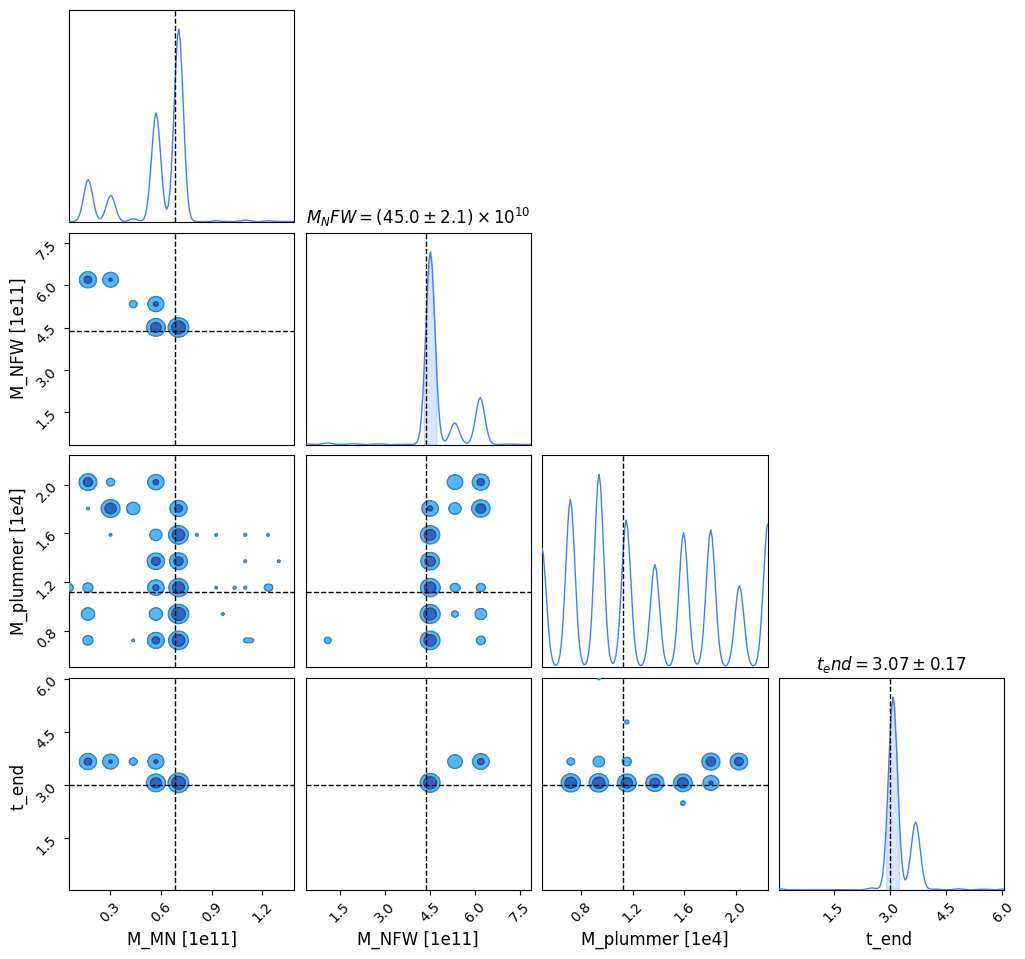

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
import pandas as pd
from chainconsumer import Chain, ChainConsumer
from scipy.stats import multivariate_normal

# Load your data
files_dir = './sampling_target_error_resampling/'
files_path = [os.path.join(files_dir, f) for f in os.listdir(files_dir) if f.endswith('.pkl')]
data = [pickle.load(open(f, 'rb')) for f in files_path]
df = pd.DataFrame(data)
df = df.astype(float)

# df = df[(df['t_end'] > 1/4 * params.t_end * code_units.code_time.to(u.Gyr)) & (df['t_end'] < 8/4 * params.t_end * code_units.code_time.to(u.Gyr))]  
# df = df[df['M_NFW'] > 1/4 * params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)]  # Filter out M_NFW < 1/4 Mvir
# df = df[df['M_NFW'] < 8/4 * params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)]  # Filter out M_NFW > 4 Mvir
# df = df[df['M_MN'] > 1/4 * params.MN_params.M * code_units.code_mass.to(u.Msun)]  # Filter out M_MN < 1/4 MN
# df = df[df['M_MN'] < 8/4 * params.MN_params.M * code_units.code_mass.to(u.Msun)]  # Filter out M_MN > 4 MN
# df = df[df['M_plummer'] > 1/4 * params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun)]  # Filter out M_Plummer < 1/4 Plummer
# df = df[df['M_plummer'] < 8/4 * params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun)]  # Filter out M_Plummer > 4 Plummer

df = df[df['t_end'] < 13  ]  # Filter out t_end < 1.5 Gyr
df = df[df['M_NFW'] > 0 ]
df = df[df['M_plummer'] > 0 ]  # Filter out M_NFW > 1e12 Msun
df = df[df['M_MN'] > 0 ]  # Filter out M_MN > 1e12 Msun

# Convert to float and handle any non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.empty:
    # If no numeric columns, convert all to float
    numeric_df = df.astype(float)

# Get statistics
mean_values = numeric_df.mean()
covariance_matrix = numeric_df.cov()
correlation_matrix = numeric_df.corr()

print("Dataset shape:", numeric_df.shape)
print("Parameter names:", list(numeric_df.columns))
print("\nMean values:")
for param, mean_val in mean_values.items():
    print(f"{param}: {mean_val:.4f}")

print("\nStandard deviations:")
for param, std_val in numeric_df.std().items():
    print(f"{param}: {std_val:.4f}")

# Create corner plot with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=numeric_df, name="Experimental Results", ), )
c.add_truth(Truth(location={
    't_end': params.t_end * code_units.code_time.to(u.Gyr), 
    'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
    'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
    'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),
}))
fig = c.plotter.plot()
plt.show()

Parameter $M_{\text{MN}}$ in chain Prior is not constrained
Parameter $M_{\text{NFW}}$ in chain Prior is not constrained
Parameter $M_{\text{Plummer}}$ in chain Prior is not constrained
Parameter $t_{\text{end}}$ in chain Prior is not constrained


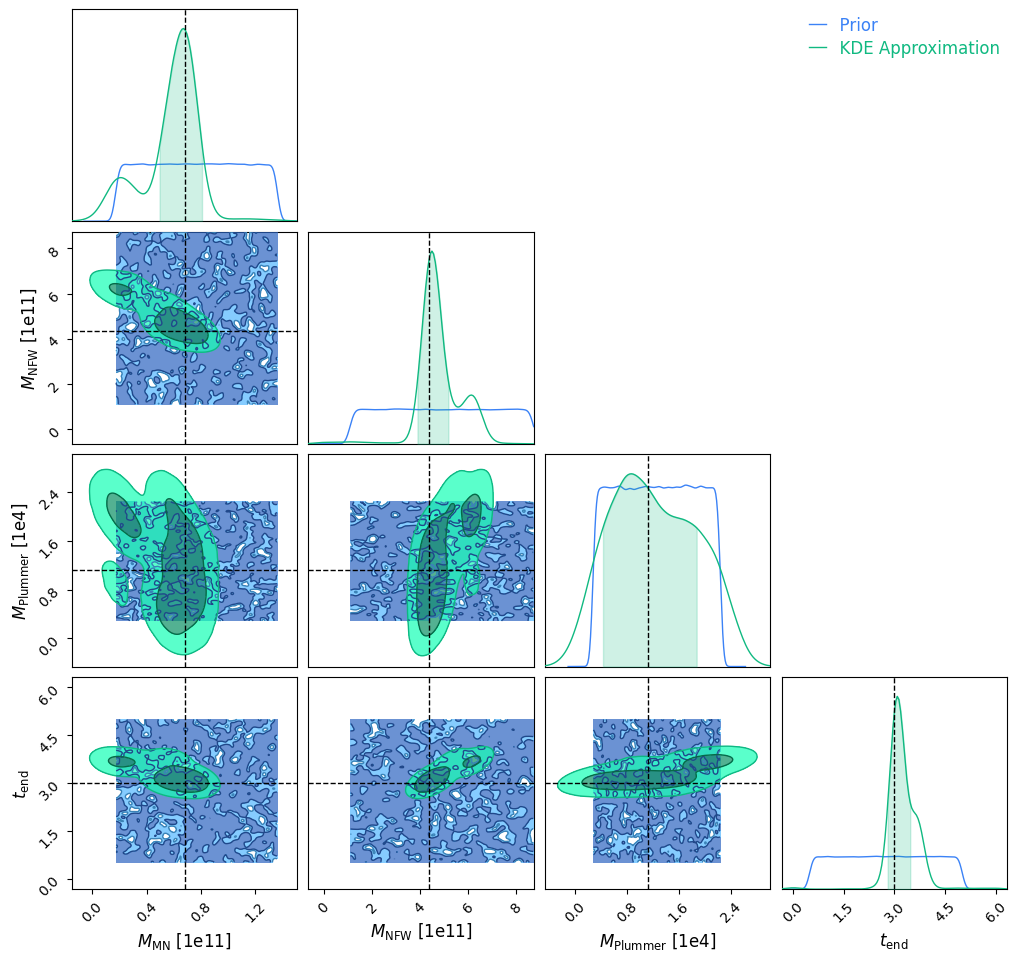

In [3]:
from scipy.stats import gaussian_kde
import numpy as np

def generate_kde_samples(df, n_samples=10000):
    """Generate samples from KDE of your data"""
    
    # Convert DataFrame to numpy array
    data_array = df.values.T  # Transpose for sklearn format
    
    # Create KDE
    kde = gaussian_kde(data_array, bw_method='silverman')  # 'scott' or 'silverman' for bandwidth selection
    
    # Generate new samples
    kde_samples = kde.resample(n_samples).T
    
    # Convert back to DataFrame
    kde_df = pd.DataFrame(kde_samples, columns=df.columns)
    
    return kde_df

df.columns = [r'$M_{\text{MN}}$', r'$M_{\text{NFW}}$', r'$M_{\text{Plummer}}$', r'$t_{\text{end}}$']

# Generate KDE samples
kde_samples_df = generate_kde_samples(df, n_samples=500_000)

df_prior = pd.DataFrame(columns=df.columns)
df_prior[r'$M_{\text{MN}}$'] = np.random.uniform(params.MN_params.M * 1/4 * code_units.code_mass.to(u.Msun),
                                                 params.MN_params.M * 8/4 * code_units.code_mass.to(u.Msun), size=500_000)
df_prior[r'$M_{\text{NFW}}$'] = np.random.uniform(params.NFW_params.Mvir * 1/4 * code_units.code_mass.to(u.Msun),
                                                 params.NFW_params.Mvir * 8/4 * code_units.code_mass.to(u.Msun), size=500_000)
df_prior[r'$M_{\text{Plummer}}$'] = np.random.uniform(params.Plummer_params.Mtot * 1/4 * code_units.code_mass.to(u.Msun),
                                                 params.Plummer_params.Mtot * 8/4 * code_units.code_mass.to(u.Msun), size=500_000)
df_prior[r'$t_{\text{end}}$'] = np.random.uniform(0.5,
                                                  5, size=500_000)

# Plot with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=df_prior, name="Prior"))
c.add_chain(Chain(samples=kde_samples_df, name="KDE Approximation"))
# c.add_chain(Chain(samples=numeric_df, name="Original Data", linestyle="--"))
c.add_truth(Truth(location={
    r'$t_{\text{end}}$': params.t_end * code_units.code_time.to(u.Gyr), 
    r'$M_{\text{Plummer}}$': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
    r'$M_{\text{NFW}}$': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
    r'$M_{\text{MN}}$': params.MN_params.M * code_units.code_mass.to(u.Msun),
}))

fig = c.plotter.plot()
plt.show()

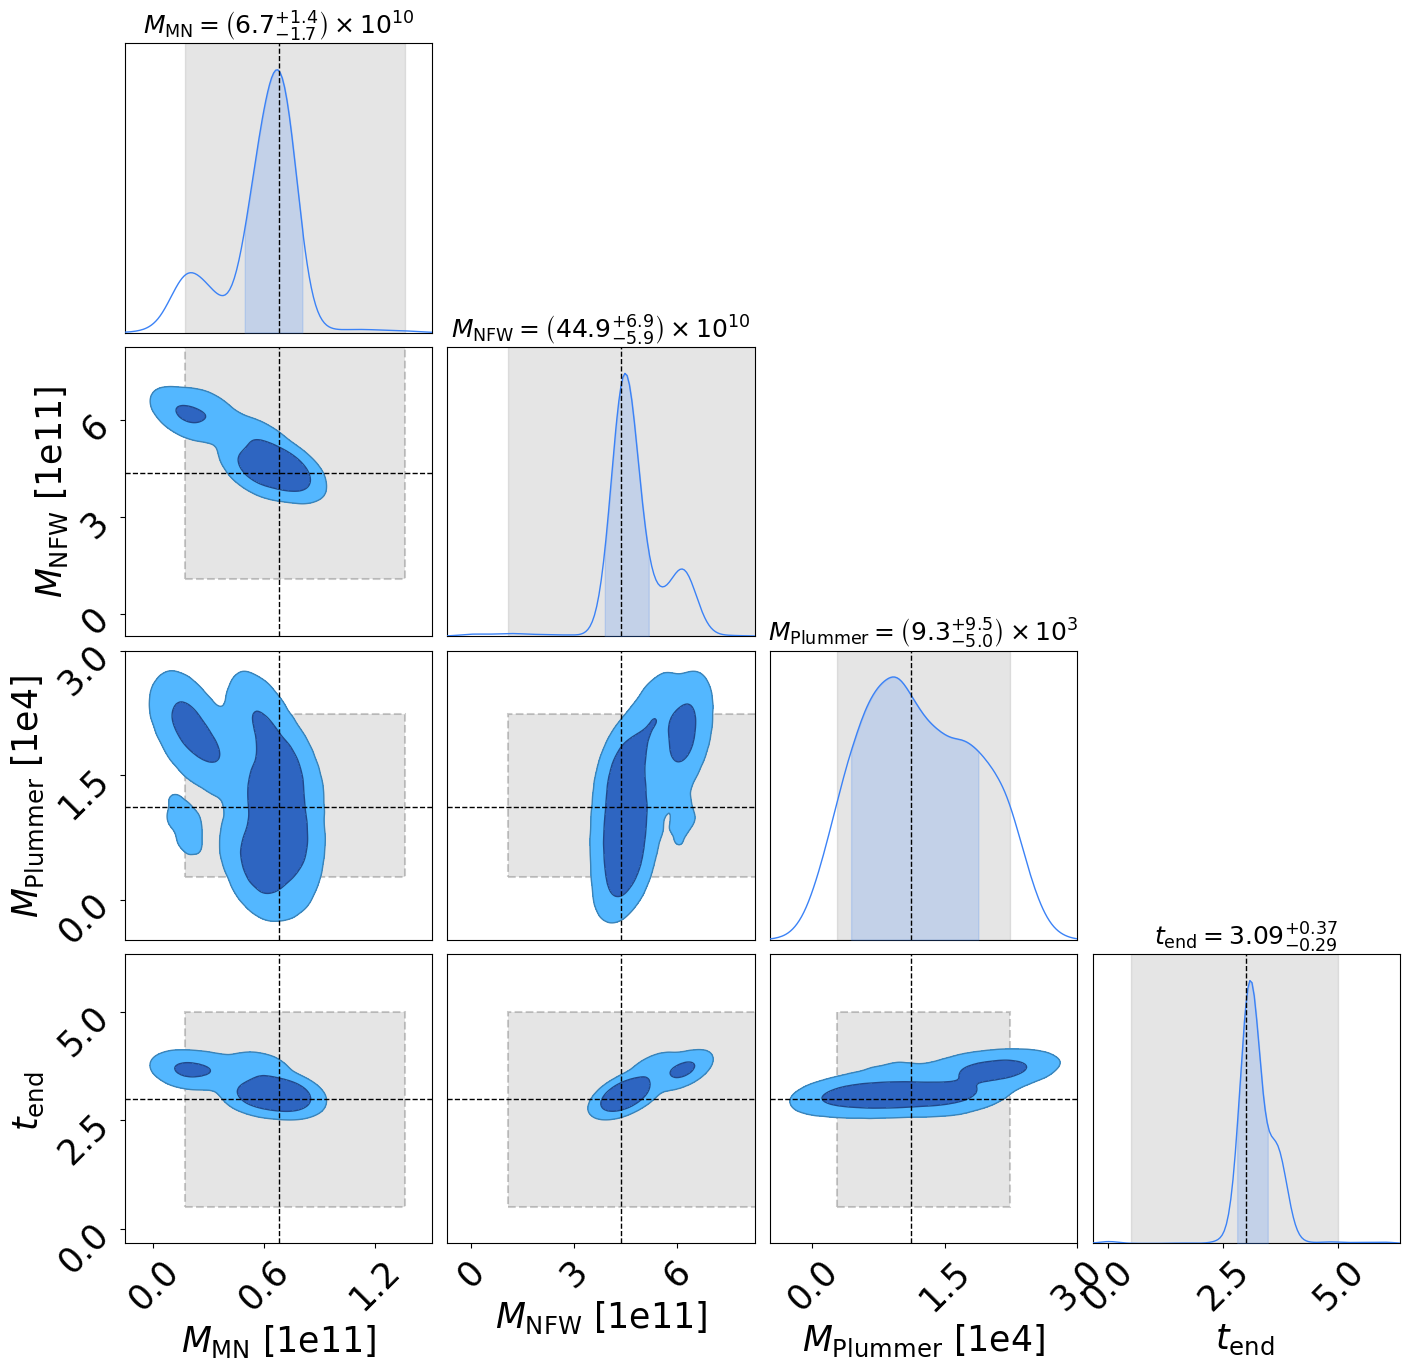

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from chainconsumer import ChainConsumer, Chain, Truth, PlotConfig


df.columns = [r'$M_{\text{MN}}$', r'$M_{\text{NFW}}$', r'$M_{\text{Plummer}}$', r'$t_{\text{end}}$']

# Generate KDE samples
kde_samples_df = generate_kde_samples(df, n_samples=500_000)

# Prior bounds
prior_bounds = {
    r'$M_{\text{MN}}$': (params.MN_params.M * 1/4 * code_units.code_mass.to(u.Msun),
                         params.MN_params.M * 8/4 * code_units.code_mass.to(u.Msun)),
    r'$M_{\text{NFW}}$': (params.NFW_params.Mvir * 1/4 * code_units.code_mass.to(u.Msun),
                          params.NFW_params.Mvir * 8/4 * code_units.code_mass.to(u.Msun)),
    r'$M_{\text{Plummer}}$': (params.Plummer_params.Mtot * 1/4 * code_units.code_mass.to(u.Msun),
                              params.Plummer_params.Mtot * 8/4 * code_units.code_mass.to(u.Msun)),
    r'$t_{\text{end}}$': (0.5, 5),
}

# Plot with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=kde_samples_df, 
                  name="KDE Approximation",
                  ))
c.add_truth(Truth(location={
    r'$t_{\text{end}}$': params.t_end * code_units.code_time.to(u.Gyr), 
    r'$M_{\text{Plummer}}$': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
    r'$M_{\text{NFW}}$': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
    r'$M_{\text{MN}}$': params.MN_params.M * code_units.code_mass.to(u.Msun),
}))

c.set_plot_config(
    PlotConfig(
        max_ticks=3,
        label_font_size=25,
        tick_font_size=25,
        summary_font_size=18,

))

fig = c.plotter.plot(figsize=1.5)


# === Overlay prior boxes ===
axes = fig.axes
n_params = len(df.columns)

for i, p1 in enumerate(df.columns):
    for j, p2 in enumerate(df.columns):
        ax = axes[i * n_params + j]

        if i == j:
            # 1D marginal → shade prior range
            low, high = prior_bounds[p1]
            ax.axvspan(low, high, color="gray", alpha=0.2, )
        elif i > j:
            # 2D subplot → add filled rectangle
            xlow, xhigh = prior_bounds[p2]
            ylow, yhigh = prior_bounds[p1]
            rect = Rectangle((xlow, ylow), xhigh - xlow, yhigh - ylow,
                             linewidth=1.5, edgecolor="black",
                             facecolor="gray", alpha=0.2, linestyle="--")
            ax.add_patch(rect)

# for ax in fig.get_axes():
#     ax.tick_params(axis="both", which="major", labelsize=20)
#     ax.tick_params(axis="both", which="minor", labelsize=20)
#     ax.xaxis.label.set_size(20)
#     ax.yaxis.label.set_size(20)
#     ax.title.set_size(20)

plt.savefig('./sampling_target_error_resampling/corner_plot.png', bbox_inches='tight')
plt.show()


Mean values:
M_MN         5.779496e+10
M_NFW        4.803133e+11
M_plummer    1.228451e+04
t_end        3.237047e+00
dtype: float64

Covariance matrix:
                   M_MN         M_NFW     M_plummer         t_end
M_MN       3.858481e+20 -9.423355e+20 -5.378888e+13 -2.409855e+09
M_NFW     -9.423355e+20  7.229555e+21  2.744213e+14  2.319676e+10
M_plummer -5.378888e+13  2.744213e+14  3.719862e+07  1.089735e+03
t_end     -2.409855e+09  2.319676e+10  1.089735e+03  1.763355e-01


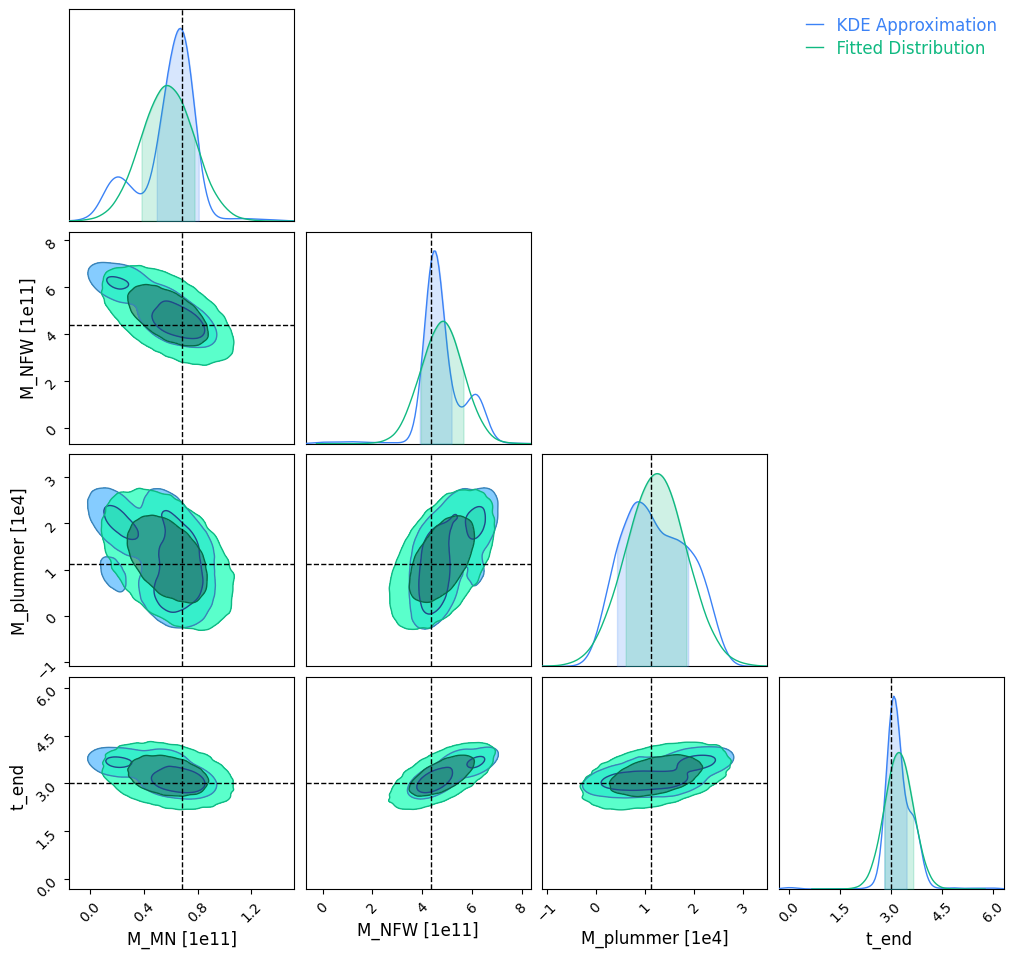

In [6]:
from scipy.stats import multivariate_normal

# Get mean and covariance from your DataFrame
mean_values = df.mean()
covariance_matrix = df.cov()

print("Mean values:")
print(mean_values)
print("\nCovariance matrix:")
print(covariance_matrix)

# Convert to numpy arrays if needed
mean_array = mean_values.values
cov_array = covariance_matrix.values

# Generate samples from the multivariate normal distribution
n_samples = 100_000
mean_array = mean_values.values
cov_array = covariance_matrix.values

# Generate new samples
generated_samples = multivariate_normal.rvs(
    mean=mean_array, 
    cov=cov_array, 
    size=n_samples
)

# Convert back to DataFrame with original column names
generated_df = pd.DataFrame(generated_samples, columns=numeric_df.columns)

# Plot both original data and generated samples
c = ChainConsumer()
c.add_chain(Chain(samples=kde_samples_df, name="KDE Approximation"))
# c.add_chain(Chain(samples=numeric_df, name="Original Data", linestyle="--"))
c.add_truth(Truth(location={'t_end': params.t_end * code_units.code_time.to(u.Gyr), 
                           'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                           'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
                           'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),}))
c.add_chain(Chain(samples=generated_df, name="Fitted Distribution"))

fig = c.plotter.plot()
plt.show()

# Plot the loss descend

In [26]:
import pickle

# Load a single pickle file
with open('./sampling_target_error_resampling/params_final_0.pkl', 'rb') as f:
    data = pickle.load(f)

In [27]:
data

{'M_MN': Array(5.682619e+10, dtype=float32),
 'M_NFW': Array(4.4891632e+11, dtype=float32),
 'M_plummer': Array(7168.452, dtype=float32),
 't_end': Array(3.0830874, dtype=float32)}